# Data Preparation
this notebook is used to reformat and extract data from the original datasets of macrizoobenthos and the environmental data.
## Start with environmental data

In [2]:
# Load libraries
import numpy as np
import pandas as pd

# macrozoobenthos data and environmental data (ices3)
ices3 = pd.read_csv('data/ices_data3.csv', header=18) # environmental data

# Select columns in environmental data
cols = ['yyyy-mm-ddThh:mm:ss.sss',
       'Latitude [degrees_north]', 'Longitude [degrees_east]',
       'Bot. Depth [m]', 'Secchi Depth [m]',
       'Depth (ADEPZZ01_ULAA) [m]',
       'Temperature (TEMPPR01_UPAA) [degC]',
       'Salinity (PSALPR01_UUUU) [dmnless]', 
       'Oxygen (DOXYZZXX_UMLL) [ml/l]',
       'Phosphate (PHOSZZXX_UPOX) [umol/l]',
       'Total Phosphorus (TPHSZZXX_UPOX) [umol/l]',
       'Silicate (SLCAZZXX_UPOX) [umol/l]',
       'Nitrate + Nitrite (NTRZZZXX_UPOX) [umol/l]',
       'Nitrate (NTRAZZXX_UPOX) [umol/l]', 
       'Nitrite (NTRIZZXX_UPOX) [umol/l]',
       'Ammonium (AMONZZXX_UPOX) [umol/l]', 
       'Total Nitrogen (NTOTZZXX_UPOX) [umol/l]',
       'Hydrogen SulphIDe (H2SXZZXX_UPOX) [umol/l]',
       'pH (PHXXZZXX_UUPH) [pH units]',
       'Total Alkalinity (ALKYZZXX_MEQL) [mEq/l]',
       'Chlorophyll a (CPHLZZXX_UGPL) [ug/l]']
ices3 = ices3[cols]


# Extract year-month-day from the datetime column
ices3['yyyy-mm-ddThh:mm:ss.sss'] = ices3['yyyy-mm-ddThh:mm:ss.sss'].astype(str)
ices3['yyyy-mm-ddThh:mm:ss.sss'].str.split(' ', expand=True)[0].str.split('T', expand=True)[0]
ices3['yyyy-mm-dd'] = pd.to_datetime(ices3['yyyy-mm-ddThh:mm:ss.sss'].str.split(' ', expand=True)[0].str.split('T', expand=True)[0])

# Aggregate the environmental data to yearly
ices3['year'] = ices3['yyyy-mm-dd'].dt.year
ices3 = ices3.drop(['yyyy-mm-ddThh:mm:ss.sss'], axis=1)
ices3.sort_values(by='yyyy-mm-dd', inplace=True)

# We see that there's a big number of missing data. I think we will forward fill and backward fill the data in time
ices3.isna().sum() / ices3.shape[0] 

# Round up the latitude and longitude to 2 decimal places
ices3['Latitude [degrees_north]'] = ices3['Latitude [degrees_north]'].round(2)
ices3['Longitude [degrees_east]'] = ices3['Longitude [degrees_east]'].round(2)

C:\Users\ttran\AppData\Local\Temp\ipykernel_22544\1275154723.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ices3 = pd.read_csv('data/ices_data3.csv', header=18) # environmental data


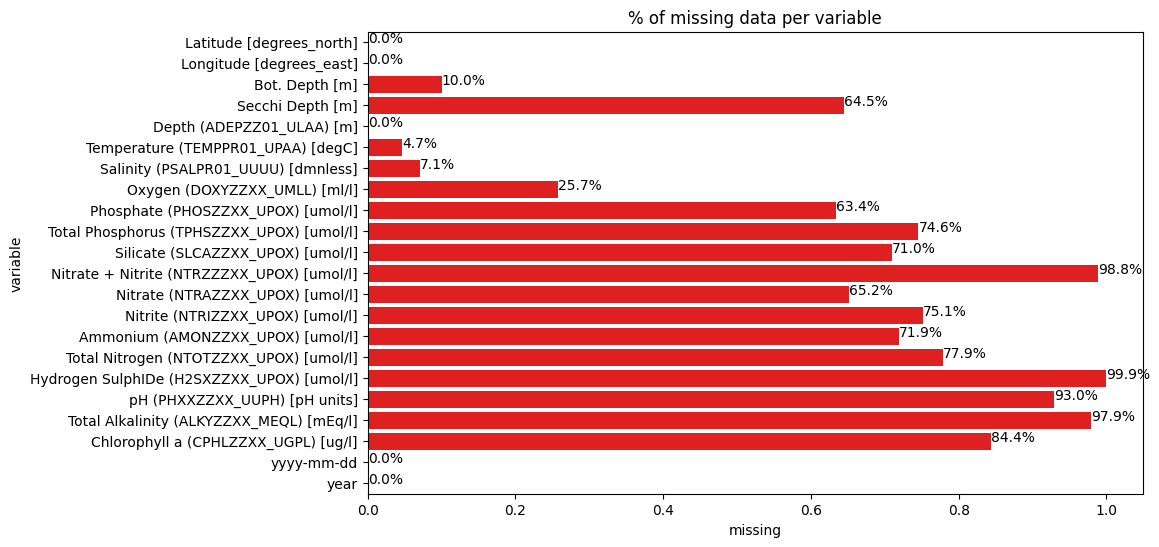

In [3]:
# Barplot for missing data per variable
import matplotlib.pyplot as plt
import seaborn as sns
missing = ices3.isna().sum() / ices3.shape[0]
missing = missing.reset_index()
missing.columns = ['variable', 'missing']
plt.figure(figsize=(10, 6))
sns.barplot(x='missing', y='variable', data=missing, color='red')
# Add text showing the percentage
for i in range(missing.shape[0]):
    plt.text(missing['missing'][i], i, '{:.1f}%'.format(missing['missing'][i]*100))
plt.title("% of missing data per variable")
plt.show()

In [4]:
# missing variables
missing_vars = ['Bot. Depth [m]', 'Secchi Depth [m]', 'Depth (ADEPZZ01_ULAA) [m]',
       'Temperature (TEMPPR01_UPAA) [degC]',
       'Salinity (PSALPR01_UUUU) [dmnless]', 'Oxygen (DOXYZZXX_UMLL) [ml/l]',
       'Phosphate (PHOSZZXX_UPOX) [umol/l]',
       'Total Phosphorus (TPHSZZXX_UPOX) [umol/l]',
       'Silicate (SLCAZZXX_UPOX) [umol/l]',
       'Nitrate + Nitrite (NTRZZZXX_UPOX) [umol/l]',
       'Nitrate (NTRAZZXX_UPOX) [umol/l]', 'Nitrite (NTRIZZXX_UPOX) [umol/l]',
       'Ammonium (AMONZZXX_UPOX) [umol/l]',
       'Total Nitrogen (NTOTZZXX_UPOX) [umol/l]',
       'Hydrogen SulphIDe (H2SXZZXX_UPOX) [umol/l]',
       'pH (PHXXZZXX_UUPH) [pH units]',
       'Total Alkalinity (ALKYZZXX_MEQL) [mEq/l]',
       'Chlorophyll a (CPHLZZXX_UGPL) [ug/l]']

# Fill in missing values
ices3[missing_vars] = ices3.groupby(['Latitude [degrees_north]', 'Longitude [degrees_east]'])[missing_vars].ffill().bfill()

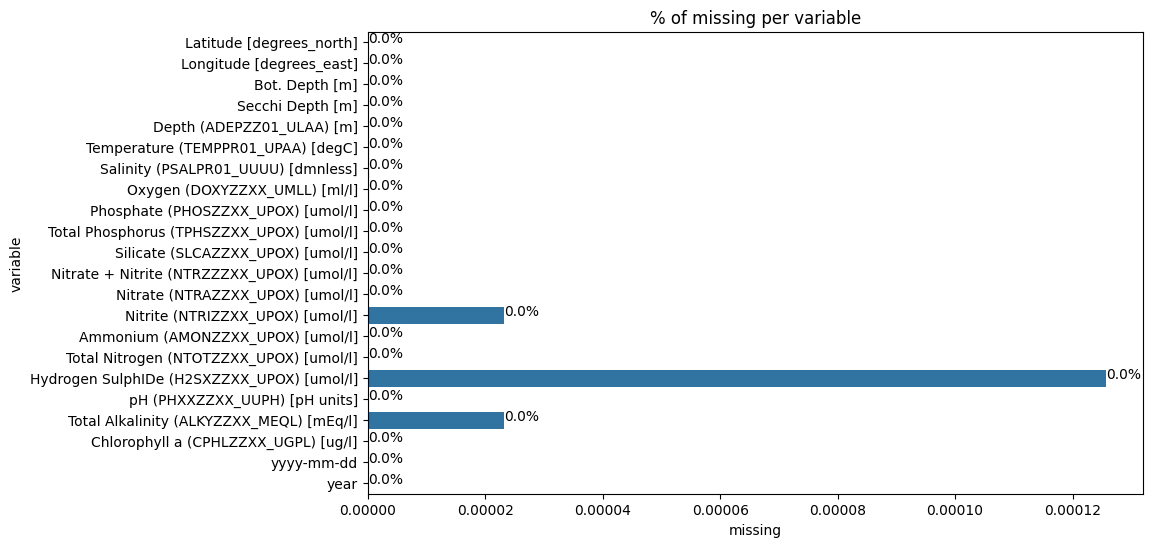

In [5]:
# Barplot for missing data per variable
missing = ices3.isna().sum() / ices3.shape[0]
missing = missing.reset_index()
missing.columns = ['variable', 'missing']
plt.figure(figsize=(10, 6))
sns.barplot(x='missing', y='variable', data=missing)

# Add text showing the percentage
for i in range(missing.shape[0]):
    plt.text(missing['missing'][i], i, '{:.1f}%'.format(missing['missing'][i]*100))
plt.title("% of missing per variable")
plt.show()

In [6]:
ices3.drop('yyyy-mm-dd', axis=1, inplace=True) # drop the datetime column

# Drop the remaining missing data
ices3.dropna(inplace=True)

# Group by location, year and aggregate the data
ices3 = ices3.groupby(['Latitude [degrees_north]', 'Longitude [degrees_east]', 'year']).mean().reset_index()

# Rename the columns
rename_cols = {'Latitude [degrees_north]': 'latitude', 
               'Longitude [degrees_east]': 'longitude',
               
                'Bot. Depth [m]' : 'bot_depth', 
                'Secchi Depth [m]' : 'secchi_depth', 
                'Depth (ADEPZZ01_ULAA) [m]' : 'depth',
                'Temperature (TEMPPR01_UPAA) [degC]' : 'temperature',
                'Salinity (PSALPR01_UUUU) [dmnless]' : 'salinity', 
                'Oxygen (DOXYZZXX_UMLL) [ml/l]' : 'oxygen',
                'Phosphate (PHOSZZXX_UPOX) [umol/l]' : 'phosphate',
                'Total Phosphorus (TPHSZZXX_UPOX) [umol/l]' : 'total_phosphorus',
                'Silicate (SLCAZZXX_UPOX) [umol/l]' : 'silicate',
                'Nitrate + Nitrite (NTRZZZXX_UPOX) [umol/l]' : 'nitrate_nitrite',
                'Nitrate (NTRAZZXX_UPOX) [umol/l]' : 'nitrate', 
                'Nitrite (NTRIZZXX_UPOX) [umol/l]' : 'nitrite',
                'Ammonium (AMONZZXX_UPOX) [umol/l]' : 'ammonium',
                'Total Nitrogen (NTOTZZXX_UPOX) [umol/l]' : 'total_nitrogen',
                'Hydrogen SulphIDe (H2SXZZXX_UPOX) [umol/l]' : 'hydrogen_sulphide',
                'pH (PHXXZZXX_UUPH) [pH units]' : 'ph',
                'Total Alkalinity (ALKYZZXX_MEQL) [mEq/l]' : 'total_alkalinity',
                'Chlorophyll a (CPHLZZXX_UGPL) [ug/l]' : 'chlorophyll_a'}

ices3.rename(columns=rename_cols, inplace=True)
ices3['site'] = 'site' + '_' + ices3['latitude'].astype(str) + '_' + ices3['longitude'].astype(str)

In [7]:
# Export data
ices3.to_csv('data/ices_data3_cleaned.csv', index=False)

# Zoobenthos Data


In [7]:
rawdf = pd.read_csv('data/raw_data_macrozoobenthos_1980-2005.csv', header=0) # original dataset

# Extract relevant columns to create Site by Abundance matrix
data = rawdf[['scientificnameaccepted', \
    'decimallatitude', 'decimallongitude', \
    'yearcollected',  'monthcollected', 'daycollected', \
     'minimumdepthinmeters', 'maximumdepthinmeters', 'Count (Dmnless)'
    ]]

# Create variable Site using latitude and longitude
data['site'] = 'site_' + data['decimallatitude'].astype(str) + '_' + data['decimallongitude'].astype(str)
data = data[['site', 'scientificnameaccepted', \
    'decimallatitude', 'decimallongitude', \
    'yearcollected',  'monthcollected', 'daycollected', \
     'minimumdepthinmeters', 'maximumdepthinmeters', 'Count (Dmnless)'
    ]]

# Filter data to only include data from 19894 to 2004
data = data[(data['yearcollected'] >= 1994) & (data['yearcollected'] <= 2004)]

# Drop month and day columns
data.drop(['monthcollected', 'daycollected'], axis=1, inplace=True)
# Group data by site and year

data = data.groupby(['site', 'yearcollected', 'scientificnameaccepted']).sum().reset_index()
data.rename(columns={'Count (Dmnless)': 'abundance',
                     'yearcollected': 'year',
                     'scientificnameaccepted': 'species',
                    'decimallatitude': 'latitude',
                    'decimallongitude': 'longitude',
                    'minimumdepthinmeters': 'min_depth',
                    'maximumdepthinmeters': 'max_depth'
                     }, inplace=True)

data['latitude'] = data['site'].str.split('_', expand=True)[1].astype(float)
data['longitude'] = data['site'].str.split('_', expand=True)[2].astype(float)


C:\Users\ttran\AppData\Local\Temp\ipykernel_22544\357564427.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['site'] = 'site_' + data['decimallatitude'].astype(str) + '_' + data['decimallongitude'].astype(str)


# Do we have environmental data for every site at every time point?

## Do we have environmental data for every site?

In [8]:
# Do we have zoobenthos data for the same sites for at least more than 5 years?
sites = data.groupby(['site'])['year'].nunique()    
print(sites)

# Filter sites with data for at least 5 years
sites = sites[sites >= 5].index
data = data[data['site'].isin(sites)]

site
site_54.03_11.37     1
site_54.11_11.18     2
site_54.18_11.75    11
site_54.22_12.09    10
site_54.32_11.55    10
site_54.47_12.2      1
site_54.55_11.33     9
site_54.63_14.28    10
site_54.71_13.95     1
site_54.72_13.7      1
site_54.73_12.79    10
site_54.93_13.5      4
site_55.0_14.08      9
site_55.25_14.51     1
site_55.25_15.98     5
Name: year, dtype: int64


In [9]:
# Create a function to returns the closest site to a given site
def closest_site(site, sites):
    """
    Function to return the closest site to a given site
    """
    site = site.split('_')[1:]
    lat = float(site[0])
    lon = float(site[1])
    closet_site = None
    min_distance = 1000000
    for s in sites:
        s = s.split('_')[1:]
        lat_s = float(s[0])
        lon_s = float(s[1])
        distance = np.sqrt((lat - lat_s)**2 + (lon - lon_s)**2)
        if distance < min_distance:
            min_distance = distance
            closet_site = "site_" + str(lat_s) + "_" + str(lon_s)
    return closet_site

# Check if we can have the closet site for each site in the data
env_sites = ices3['site'].unique()
data_sites = data['site'].unique()
for s in data_sites:
    if s not in env_sites:
        closet_site = closest_site(s, env_sites)
        print("No information for site {}. Closest site is {}".format(s, closet_site))
    else:
        print("Information available for site {}".format(s))

No information for site site_54.18_11.75. Closest site is site_54.18_11.76
Information available for site site_54.22_12.09
Information available for site site_54.32_11.55
Information available for site site_54.55_11.33
Information available for site site_54.63_14.28
Information available for site site_54.73_12.79
Information available for site site_55.0_14.08
No information for site site_55.25_15.98. Closest site is site_55.28_15.0


In [103]:
# closest_site('site_54.22_12.09', env_sites)

- We see that there are 3\2 sites in the `data` that don't have a match in the `env` data.
  
- For the sites in `data` where we couldn't find a perfect match for the location. We will look at the species abundance over time and see if we would want to remove these sites from the dataset.

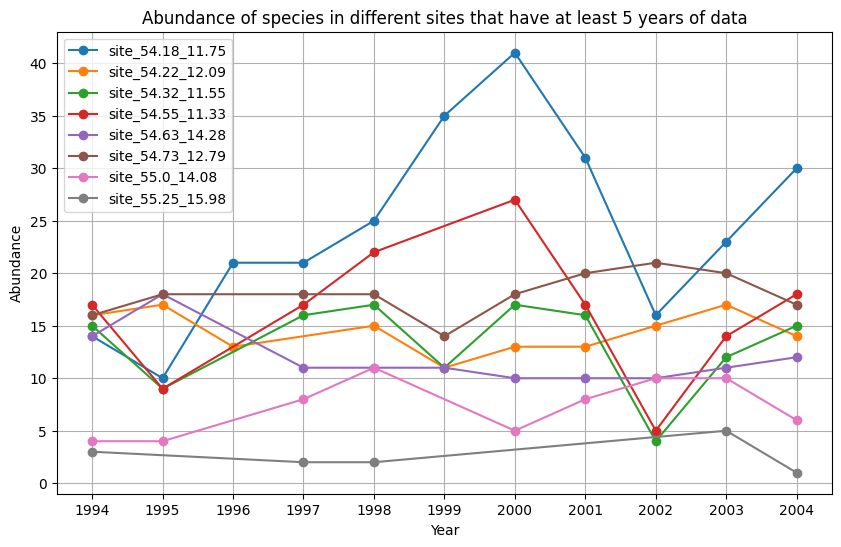

In [10]:
data_plot = data.groupby(['site', 'year'])['abundance'].nunique().reset_index()
plt.figure(figsize=(10, 6))
for s in data['site'].unique():
    d = data_plot[data_plot['site'] == s]
    plt.plot(d['year'], d['abundance'], label=s, marker='o', linestyle='-')

plt.legend()
# Grid at every year
plt.grid()
plt.xlabel('Year')
plt.xticks(data_plot['year'].unique())
plt.ylabel('Abundance')
plt.title('Abundance of species in different sites that have at least 5 years of data')
plt.show()

Maybe we take year 94, 97, 2000,2003 ?
We drop the site_55.25_15.98


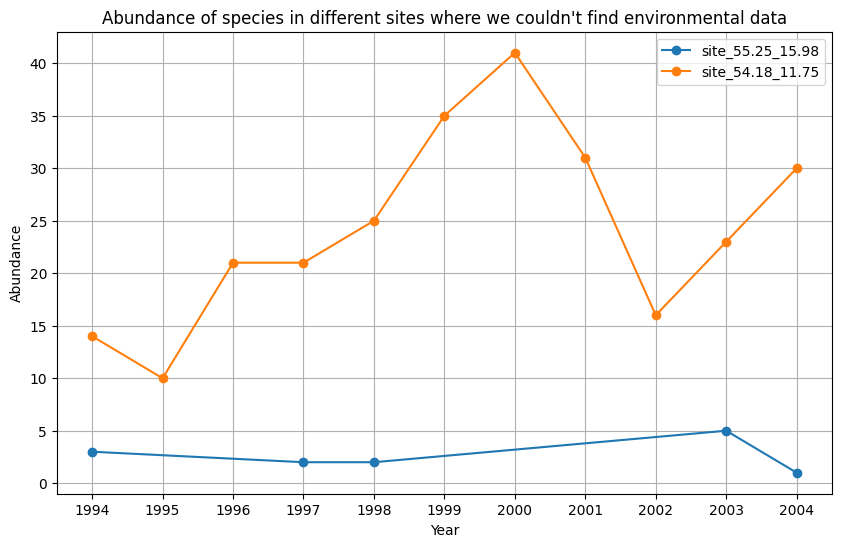

In [11]:
data_plot = data.groupby(['site', 'year'])['abundance'].nunique().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(data_plot[data_plot['site'] == 'site_55.25_15.98']['year'], 
         data_plot[data_plot['site'] == 'site_55.25_15.98']['abundance'], label='site_55.25_15.98',
         marker='o')
plt.plot(data_plot[data_plot['site'] == 'site_54.18_11.75']['year'],
        data_plot[data_plot['site'] == 'site_54.18_11.75']['abundance'], label='site_54.18_11.75',
        marker='o')
plt.legend()
# Grid at every year
plt.grid()
plt.xlabel('Year')
plt.xticks(data_plot['year'].unique())
plt.ylabel('Abundance')
plt.title('Abundance of species in different sites where we couldn\'t find environmental data')
plt.show()

I think we can drop site_55.25_15.98 without issue

In [12]:
# Replace values in the data for the column site
data['site'] = data['site'].apply(lambda x: closest_site(x, env_sites))

In [18]:
data['site'].unique()

# Remove site_55.25_15.98
data = data[data['site'] != 'site_55.25_15.98']
# data = data[data['year'].isin([1994, 1997, 2000, 2003])]


### Do we have environmental data for every time point for each site?

In [28]:
# data['year'].unique()

array([1994, 1997, 2000, 2003])

In [14]:
# Check if we can have the closet site for each site in the data
env_sites = ices3['site'].unique()
data_sites = data['site'].unique()
nb_years = data['year'].unique().shape[0]

for s in data_sites:
    print("Site: ", s)
    counter = 0
    for y in data['year'].unique():
        data_y = data[data['year'] == y]
        # print("Year: ", y)
        if s not in env_sites:
            closet_site_s = closest_site(s, env_sites)
            # Check if there is environmental data for the closest site at the same year
            if ices3[(ices3['site'] == closet_site_s) & (ices3['year'] == y)].shape[0] == 0:
                print("No envr information for site {} (using closest site {}) in year {} in environmental data set".format(s, closet_site_s, y))
            else:
                counter += 1
                print("Envr information available not site {} but for closest site {} in year {}".format(s, closet_site_s, y))
        else:
            if ices3[(ices3['site'] == s) & (ices3['year'] == y)].shape[0] == 0:
                print("No envr information for site {} in year {} in environmental data set".format(s, y))
            else:
                counter += 1
                print("Envr information available for site {} in year {}".format(s, y))
    print("Number of years with envr information: {} for site {}".format(counter, s))
    print("-"*20 +"\n")

Site:  site_54.18_11.76
No envr information for site site_54.18_11.76 in year 1994 in environmental data set
Envr information available for site site_54.18_11.76 in year 1995
No envr information for site site_54.18_11.76 in year 1996 in environmental data set
No envr information for site site_54.18_11.76 in year 1997 in environmental data set
No envr information for site site_54.18_11.76 in year 1998 in environmental data set
No envr information for site site_54.18_11.76 in year 1999 in environmental data set
No envr information for site site_54.18_11.76 in year 2000 in environmental data set
No envr information for site site_54.18_11.76 in year 2001 in environmental data set
No envr information for site site_54.18_11.76 in year 2002 in environmental data set
No envr information for site site_54.18_11.76 in year 2003 in environmental data set
No envr information for site site_54.18_11.76 in year 2004 in environmental data set
Number of years with envr information: 1 for site site_54.18

In [15]:
# ices3

## Checking temperature evolution over years

C:\Users\ttran\AppData\Local\Temp\ipykernel_22544\104590267.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


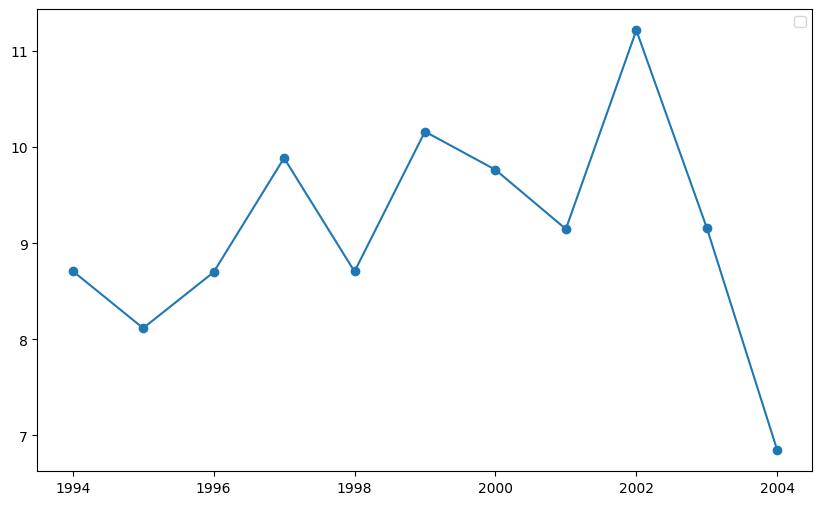

In [19]:
plt.figure(figsize=(10, 6))
d = ices3.groupby(['year'])['temperature'].mean().reset_index()
d = d[(d['year'] >=1994) & (d['year'] <= 2004)]
plt.plot(d['year'], d['temperature'], marker='o')
# Calculate moving average
# window_size = 2 # Adjust as needed
# d['moving_average'] = d['temperature'].rolling(window=window_size).mean()

# Plot the data
# plt.plot(d['te'], label='Original Data')
# plt.plot(d['year'], d['moving_average'], label='Moving Average')
plt.legend()
plt.show()
# plt.plot(ices3['year'], ices3['abundance'], marker='o')

### Conclusions:
- Not all sites have data for every time point. Some have very few data points. We will drop these sites from the dataset. We will drop sites that have less than 5 data points.
- They are : 
  - 'site_54.18_11.76', 
  - 'site_54.22_12.09', 
  - 'site_54.55_11.33'
  - 'site_54.73_12.79', 
  - 'site_55.28_15.0'


In [20]:
# Drop sites
data = data[~data['site'].isin(['site_54.73_12.79', 
                                'site_54.18_11.76', 
                                'site_54.22_12.09', 
                                'site_54.55_11.33', 
                                'site_55.28_15.0'])]

We will keep 3 sites, and look at the species abundance over time.

Text(0.5, 1.0, 'Abundance of species in different sites')

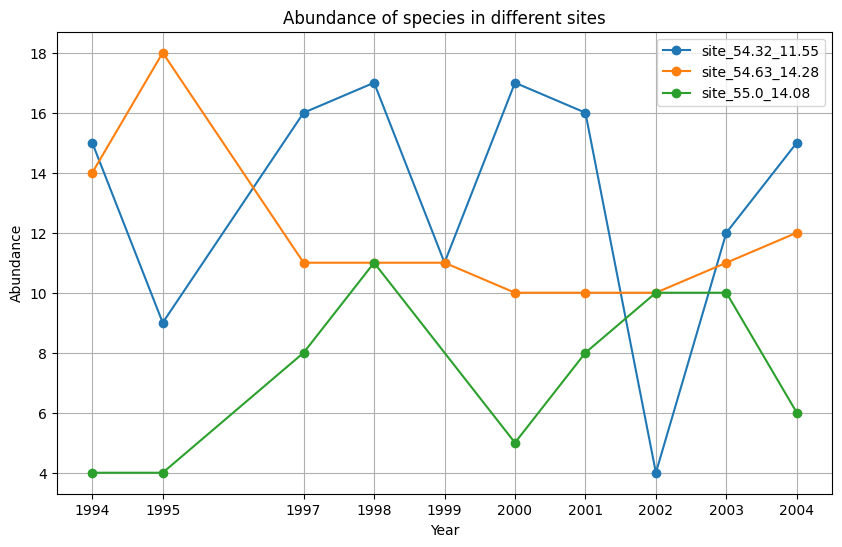

In [21]:
# Plot abundance of species in different sites over the years
data_plot = data.groupby(['site', 'year'])['abundance'].nunique().reset_index()
plt.figure(figsize=(10, 6))
for s in data['site'].unique():
    plt.plot(data_plot [data_plot ['site'] == s]['year'], 
             data_plot [data_plot ['site'] == s]['abundance'], label=s,
             marker='o')
plt.legend()
# Grid at every year
plt.grid()
plt.xlabel('Year')
plt.xticks(data_plot['year'].unique())
plt.ylabel('Abundance')
plt.title('Abundance of species in different sites')

Apparently something went wrong in 1996, we don't have data at that year.

# Merge data and env data

In [22]:
# Merge the data
df = pd.merge(data, ices3, how='left', on=['site', 'year'])

# Export data
df.to_csv('data/merged_data.csv', index=False)
data.to_csv('data/zoobenthos_data.csv', index=False)
ices3.to_csv('data/environmental_data.csv', index=False)

In [124]:
df

,site,year,species,latitude_x,longitude_x,min_depth,max_depth,abundance,latitude_y,longitude_y,...,silicate,nitrate_nitrite,nitrate,nitrite,ammonium,total_nitrogen,hydrogen_sulphide,ph,total_alkalinity,chlorophyll_a
0,site_54.32_11.55,1994,Abra alba,54.32,11.55,25.0,25.0,384,54.32,11.55,...,10.553165,4.280000,3.231013,0.243671,0.853165,19.400000,1.200000,8.080000,1.587000,2.718418
1,site_54.32_11.55,1994,Ampharete acutifrons,54.32,11.55,25.0,25.0,22,54.32,11.55,...,10.553165,4.280000,3.231013,0.243671,0.853165,19.400000,1.200000,8.080000,1.587000,2.718418
2,site_54.32_11.55,1994,Arctica islandica,54.32,11.55,25.0,25.0,85,54.32,11.55,...,10.553165,4.280000,3.231013,0.243671,0.853165,19.400000,1.200000,8.080000,1.587000,2.718418
3,site_54.32_11.55,1994,Bylgides sarsi,54.32,11.55,25.0,25.0,19,54.32,11.55,...,10.553165,4.280000,3.231013,0.243671,0.853165,19.400000,1.200000,8.080000,1.587000,2.718418
4,site_54.32_11.55,1994,Capitella capitata,54.32,11.55,25.0,25.0,14,54.32,11.55,...,10.553165,4.280000,3.231013,0.243671,0.853165,19.400000,1.200000,8.080000,1.587000,2.718418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,site_55.0_14.08,2004,Nephtys hombergii,55.00,14.08,48.0,48.0,16,55.00,14.08,...,8.929487,4.964167,1.457051,0.206026,0.264744,19.601923,5.292308,8.201346,1.645385,1.957051
555,site_55.0_14.08,2004,Pontoporeia femorata,55.00,14.08,48.0,48.0,16,55.00,14.08,...,8.929487,4.964167,1.457051,0.206026,0.264744,19.601923,5.292308,8.201346,1.645385,1.957051
556,site_55.0_14.08,2004,Priapulus caudatus,55.00,14.08,48.0,48.0,1,55.00,14.08,...,8.929487,4.964167,1.457051,0.206026,0.264744,19.601923,5.292308,8.201346,1.645385,1.957051
557,site_55.0_14.08,2004,Terebellides stroemii,55.00,14.08,48.0,48.0,3,55.00,14.08,...,8.929487,4.964167,1.457051,0.206026,0.264744,19.601923,5.292308,8.201346,1.645385,1.957051


# Create SbS data per year and environmental data per year

In [125]:
envr_vars = ['bot_depth', 'secchi_depth', 'depth',
       'temperature', 'salinity', 'oxygen', 'phosphate', 'total_phosphorus',
       'silicate', 'nitrate_nitrite', 'nitrate', 'nitrite', 'ammonium',
       'total_nitrogen', 'hydrogen_sulphide', 'ph', 'total_alkalinity',
       'chlorophyll_a']
for y in data['year'].unique():
    print("Year: ", y)
    df_y = df[df['year'] == y]
    data_y = data[data['year'] == y]
    # Pivot data by site and species
    data_y = data_y.pivot(index='site', columns='species', values='abundance').reset_index()
    data_y = data_y.fillna(0)
    data_y.to_csv('data/sys/zoobenthos_data_' + str(y) + '.csv', index=False)
    df_v = df_y[['site'] + envr_vars].drop_duplicates()
    df_v.to_csv('data/env/envar_' + str(y) + '.csv', index=False)
       

Year:  1994
Year:  1995
Year:  1997
Year:  1998
Year:  1999
Year:  2000
Year:  2001
Year:  2002
Year:  2003
Year:  2004


## Create site by species data per year


In [25]:
merged_data = pd.read_csv('data/merged_data.csv', header=0)
merged_data['site_year'] = merged_data['site'] + '_' + merged_data['year'].astype(str)
merged_data.to_csv('data/merged_data_full.csv', index=False)

In [115]:
ices3.columns

Index(['latitude', 'longitude', 'year', 'bot_depth', 'secchi_depth', 'depth',
       'temperature', 'salinity', 'oxygen', 'phosphate', 'total_phosphorus',
       'silicate', 'nitrate_nitrite', 'nitrate', 'nitrite', 'ammonium',
       'total_nitrogen', 'hydrogen_sulphide', 'ph', 'total_alkalinity',
       'chlorophyll_a', 'site'],
      dtype='object')